 This notebook implements backpropagation (reverse-mode autodiff) over a dynamically built DAG and a small neural networks library on top of it with a PyTorch-like API. This is enough to build up entire deep neural nets doing binary classification. Main Education Sources: https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1&t=8546s

## 1. Derivatives Fundamentals

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

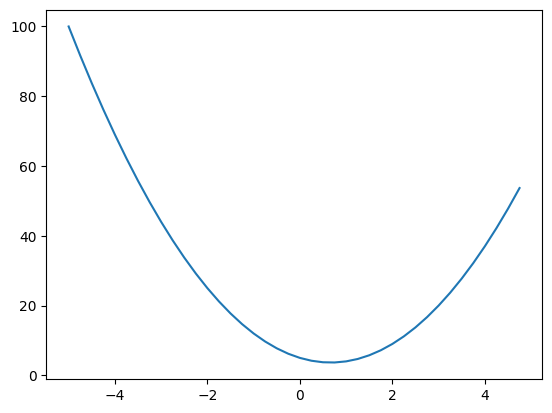

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

- What is the derivatives of different point X of this function?

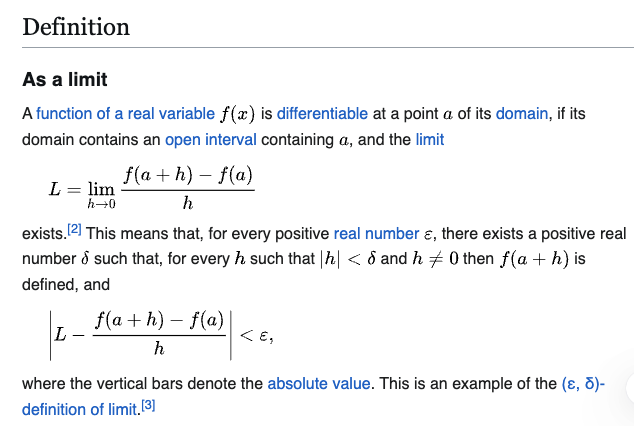

- If we slightly bump up **at some point x (or a) we're interested in** by a small number ***h***, how does the function response with what's the sensitivity does it respond == slope at that point:
- Does the function go up or go down

In [ ]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
# b += h
# c += h --> at point c, d will increase by
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope: ", (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope:  -3.000000000010772


## 2. **AutoGrad** build out

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

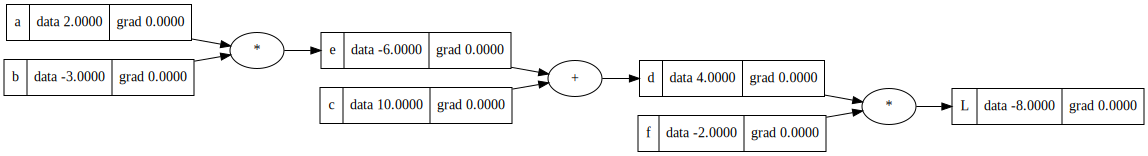

In [ ]:
draw_dot(L)

- L = d * f
- What is dL/dd? & dL/df

### Chain Rule:
- dL / dc = (dL / dd) * (dd / dc)
  - dd/dc?
  - dL/dd?

--> Intuitively, the chain rule states that knowing the instantaneous rate of change of z relative to y and that of y relative to x allows one to calculate the instantaneous rate of change of z relative to x as the product of the two rates of change.

- As put by George F. Simmons: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

In [ ]:
## Single optimization step

a.data += 0.01 * a.grad
b.data += 0.01 * a.grad
c.data += 0.01 * a.grad
f.data += 0.01 * a.grad

e = a*b
d = e + c
L = d * f;
print(L)

Value(data=-8.0)


In [ ]:
def lol():

  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  d.data += h
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

In [ ]:
lol()

-1.9999999999953388


## 3. Backprop through a Neuron

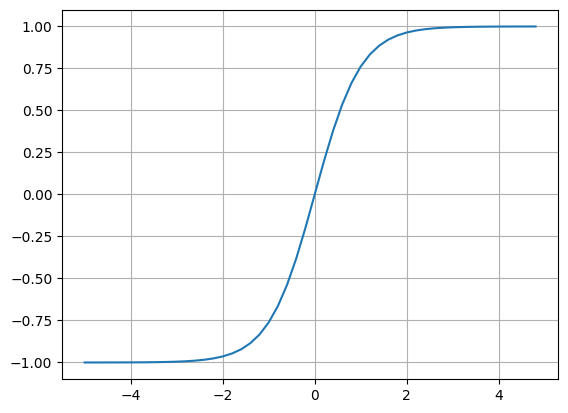

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

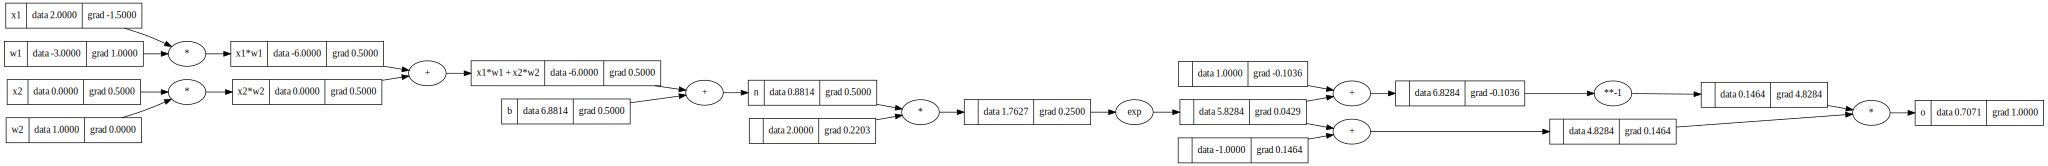

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

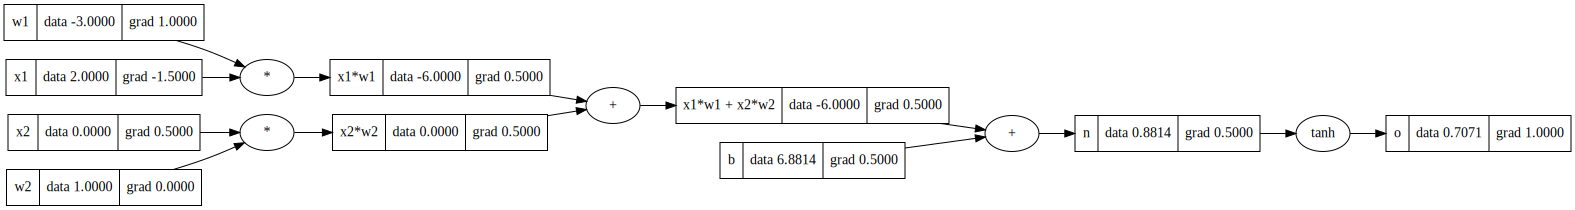

In [ ]:
draw_dot(o)

In [ ]:
o.backward()

#### Manually adjust grad in the graph

In [ ]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [ ]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [ ]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [ ]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

In [ ]:
n.grad = 0.5

In [ ]:
# o = tanh(n) --> do / dn = 1 - o**2 (local derivatives of tanh)
o.grad = 1.0

#### Call Backward()

In [ ]:
o.grad = 1.0

In [ ]:
o._backward()

In [ ]:
n._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x2w2._backward()
x1w1._backward()

### 4. Pytorch

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### 5. Building out a neural net library (multi-layer perceptron) in micrograd

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8712888492513264)

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)


0 6.869855059433045
1 5.182709135603982
2 2.9184911974784846
3 2.3553432796090856
4 0.3262055328837525
5 0.12297439875711423
6 0.08962090043330742
7 0.07082569202826575
8 0.05849064412995404
9 0.04973387477774811
10 0.04319263371447441
11 0.038123523641885634
12 0.034083185352379565
13 0.03079000440571713
14 0.028056335111078544
15 0.025752298963727722
16 0.023785156531817078
17 0.022086937243786707
18 0.020606704868410812
19 0.019305549260582595
